# Anomalías

El enfoque de detección de anomalías (también conocido como valores atípicos o extraños), basado en el análisis de componentes principales (PCA) se ha utilizado con éxito para monitorear sistemas con variables altamente correlacionadas.

En este **notebook** se propone un esquema de detección de anomalías basado en PCA, sobre un conjunto de datos que representan imágenes de perros y gatos, con la intención de revelar si una imagen particular es un gato o no. Probaremos eventualmente también el caso contrario.

In [7]:
## Cargamos los datos
load("gatosperros.RData")

## Los cuales contienen la siguiente información
head(dm)

23,23,20,20,9,9,9,4,4,4,...,108,108,108,108,89,65,51,31,23,9
250,250,250,244,244,244,244,244,232,232,...,244,244,244,232,244,244,244,244,232,244
137,137,137,144,151,151,151,158,151,151,...,74,89,89,78,78,78,100,102,124,124
55,55,55,55,55,55,55,55,55,55,...,45,45,45,45,45,45,45,37,45,52
173,173,173,173,158,158,158,158,153,149,...,45,64,64,48,48,77,98,64,45,45
18,18,18,13,13,13,18,22,18,13,...,70,85,85,85,85,70,70,62,62,70


Dichos datos son un representación numérica de los colores de 64x64 pixeles que componen cada imágen. Asi entonces, cada fila de la matríz anterior contiene 4096 valores numéricos que completan una única imagen. Por otra parte las primeras 99 filas contienen datos de imagenes de gatos, y las restantes son perros.

Para representar estos datos como una imagen, resulta necesario definir la siguiente función, que simplemente transforma cada fila vector en una matriz de 64x64, la cual es enviada como parámetro a la función de *R* 'image()' que crea una cuadrícula de rectángulos coloreados o en escala de grises con colores dependiendo de los valores datos en la matriz

In [8]:
## función de graficación
plotcd <- function(v){
  x <- matrix(v,64,64)
  image(1:65,1:65,t(apply(x,2,rev)),asp=1,xaxt="n",yaxt="n",
        col=grey((0:255)/255),ann=FALSE,bty="n")
}

Vamos a partir ahora los datos en dos conjuntos diferentes, uno para entrenamiento del modelo basado en PCA, y otro para probar la eficiencia del mismo. Recordemos que el conjunto de datos contiene información para perros y gatos, por lo que habrá que definir entonces 4 conjuntos de datos. 

In [9]:
set.seed(1013596884)
ind.gatostest <- sample(1:99, 29
                        , replace = FALSE)
gatos.test <- dm[ind.gatostest, ]
gatos.train <- dm[1:99, ][-ind.gatostest, ]

ind.perrostest <- sample(1:99, 29, replace = FALSE)
perros.test <- dm[100:198, ][ind.perrostest, ]
perros.train <- dm[100:198, ][-ind.perrostest, ]


El análisis de componentes principales buscará abstraer las características mas relevantes que describen a un gato (o perro). Para lograr una buena abstracción, es necesario normalizar los datos, ya que cada columna (variable o caractrística) de nuestros datos, pueden estar definidas entre rangos de valores muy distintos, donde las variables con mayor rango de variabilidad lograrían opacar a las demás variables.  

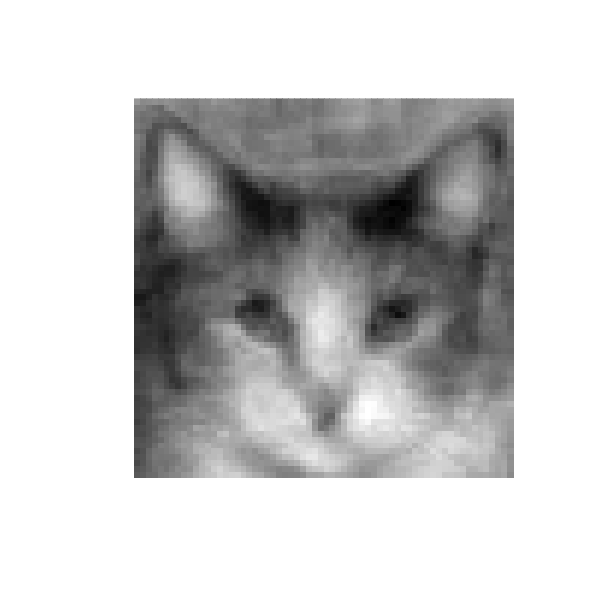

In [12]:
## Calculamos el gato promedio
centro.gatos <- colMeans(gatos.train)

## Lo graficamos
library(repr); options(repr.plot.width=5, repr.plot.height=5)
plotcd(centro.gatos)

Normalizamos los datos de la siguiente manera

In [13]:
## Normalización de gatos y perros
gatos.train <- gatos.train -
               matrix(centro.gatos, nrow(gatos.train), ncol(gatos.train), byrow=TRUE)
gatos.test <- gatos.test -
              matrix(centro.gatos, nrow(gatos.test), ncol(gatos.test), byrow=TRUE)
perros.train <- perros.train -
                matrix(centro.gatos, nrow(perros.train), ncol(perros.train), byrow=TRUE)
perros.test <- perros.test -
               matrix(centro.gatos, nrow(perros.test), ncol(perros.test), byrow=TRUE)

## PCA sobre los gatos
Iniciamos el analísis de componentes principales sobre los datos asociados a gatos, tal como sigue a continuación

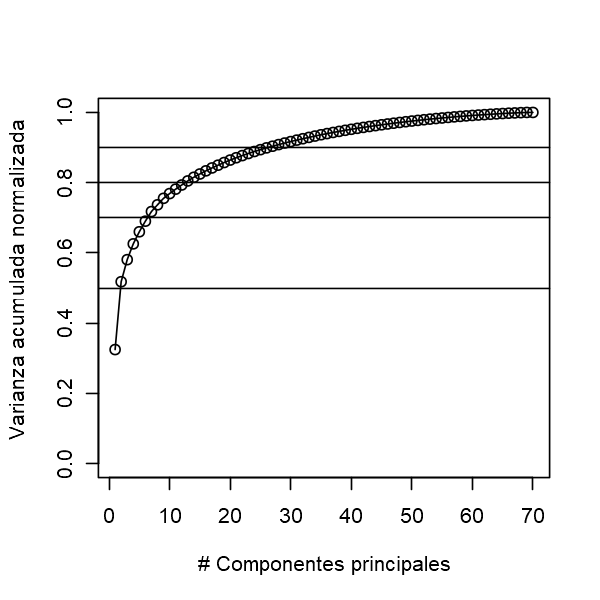

In [17]:
## PCA
pc <- prcomp(gatos.train)

## Matriz de proyección generada por la función anterior
matriz.proyec <- pc$rotation

## Visualización de la varianza acumulada por cada componente principal
plot(cumsum(pc$sdev^2)/sum(pc$sdev^2),type="o",ylim=c(0,1),
     ylab="Varianza acumulada normalizada", xlab="# Componentes principales")
abline(h=0.5)
abline(h=0.7)
abline(h=0.8)
abline(h=0.9)

Cada línea representa gráficamente el número de componentes necesario para conservar el {50, 80, 90, 95, 99}% de la varianza. Los valores precisos están dados a continuación


In [18]:
## Vector de varianza ganada
var_ganada <- cumsum(pc$sdev^2)/sum(pc$sdev^2)

## Componentes que garantizan x% de varianza
which(var_ganada>0.5)[1] # 2 componentes
which(var_ganada>0.8)[1] # 13 componentes
which(var_ganada>0.9)[1] # 27 componentes
which(var_ganada>0.95)[1] # 40 componentes
which(var_ganada>0.99)[1] # 59 componentes

[1] 2

[1] 13

[1] 27

[1] 40

[1] 59

A continuación se "des-proyectan" los valores asociados a cada imágen, es decir, se re- proyecta la transformación inicial en los ejes originales.

In [19]:
gatos.train.proyec <- (gatos.train %*% matriz.proyec) %*% t(matriz.proyec)


Con la siguiente línea se obtienen los errores asociados a la re-proyección del paso anterior. Si los residuales son pequeños, significa que la imágen corresponde a un gato, en otro caso sería un perro u otra cosa (asumimos perro puesto que la base unicamente tiene perros y gatos)

In [20]:
## Residuales de la re-proyección
gatos.train.resid <- gatos.train - gatos.train.proyec

Puesto que se han centrado los datos, y asumiendo además que se han tomado todas las componentes principales, el residuo de proyección es siempre cero para los datos de entrenamiento. Lo anterior se puede evidencar en la siguiente imagen, donde el color uniforme de la imagen de los residuos demuestra lo anteriormente dicho.

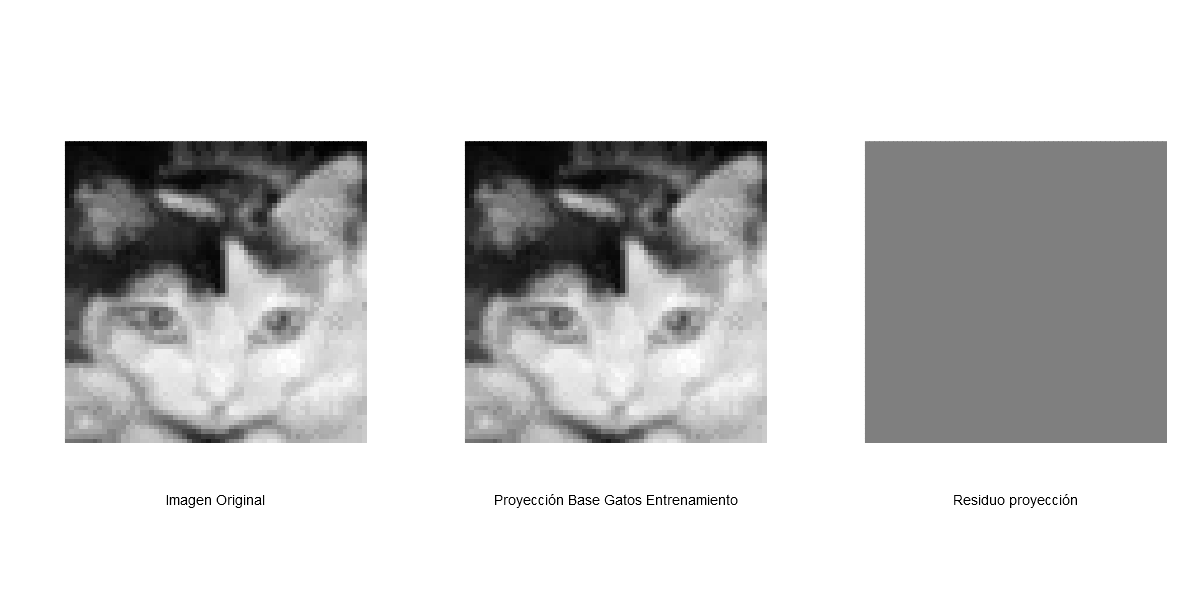

In [23]:
## Datos a graficar
options(repr.plot.width=10, repr.plot.height=5)
par(pty="s")
layout(matrix(1:3,1,3))
ind <- sample(1:nrow(gatos.train),1)

## Proyección de las imágenes resultado
plotcd(round(gatos.train[ind,]))
title(xlab = "Imagen Original")
plotcd(round(gatos.train.proyec[ind,]))
title(xlab="Proyección Base Gatos Entrenamiento")
plotcd(round(gatos.train.resid[ind,]))
title(xlab = "Residuo proyección")

La siguiente linea calcula la norma de cada cada vector fila. type=2 especifica la descomposición en valores singulares. Se muestra con ello el valor de los errores de proyección, para cada componente empleada

In [37]:
gatos.train.resid.norm <- apply(gatos.train.resid, 1, norm, type="2")
round(mean(gatos.train.resid.norm))

[1] 0

Lo que se busca ahora, es utilizar la matriz de proyección que usamos en líneas anteriores, para proyectar el conjunto de gatos de prueba. Se espera que los errores de proyección sean bajos.

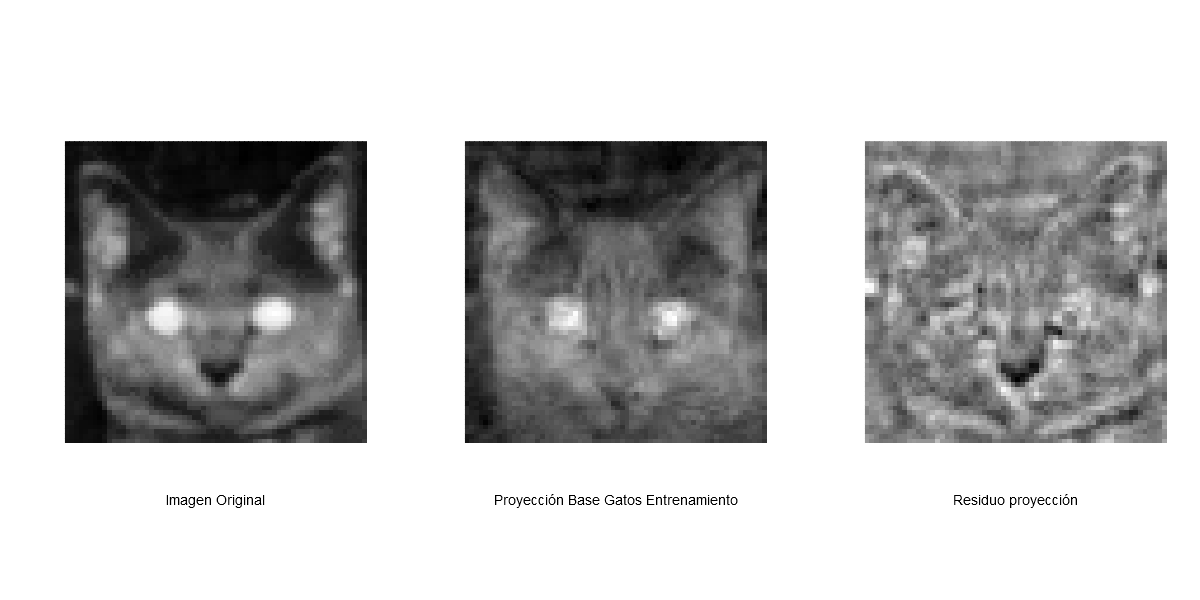

In [31]:
## Proyección de gatos de prueba
gatos.test.proyec <- (gatos.test %*% matriz.proyec) %*% t(matriz.proyec)
gatos.test.resid <- gatos.test - gatos.test.proyec

## Parámetros para la gráfica
par(pty="s")
layout(matrix(1:3,1,3))

## Seleccionamos un gato de forma aleatoria 
ind <- sample(1:nrow(gatos.test),1)

## Graficamos el gato de prueba
plotcd(round(gatos.test[ind,]))
title(xlab = "Imagen Original")
plotcd(round(gatos.test.proyec[ind,]))
title(xlab="Proyección Base Gatos Entrenamiento")
plotcd(round(gatos.test.resid[ind,]))
title(xlab = "Residuo proyección")

In [38]:
## encontramos el error medio de proyección
gatos.test.resid.norm <- apply(gatos.test.resid, 1, norm, type="2")
mean(gatos.test.resid.norm)

[1] 2037.451

#### Proyección de los perros sobre el PCA aplicado a gatos
...

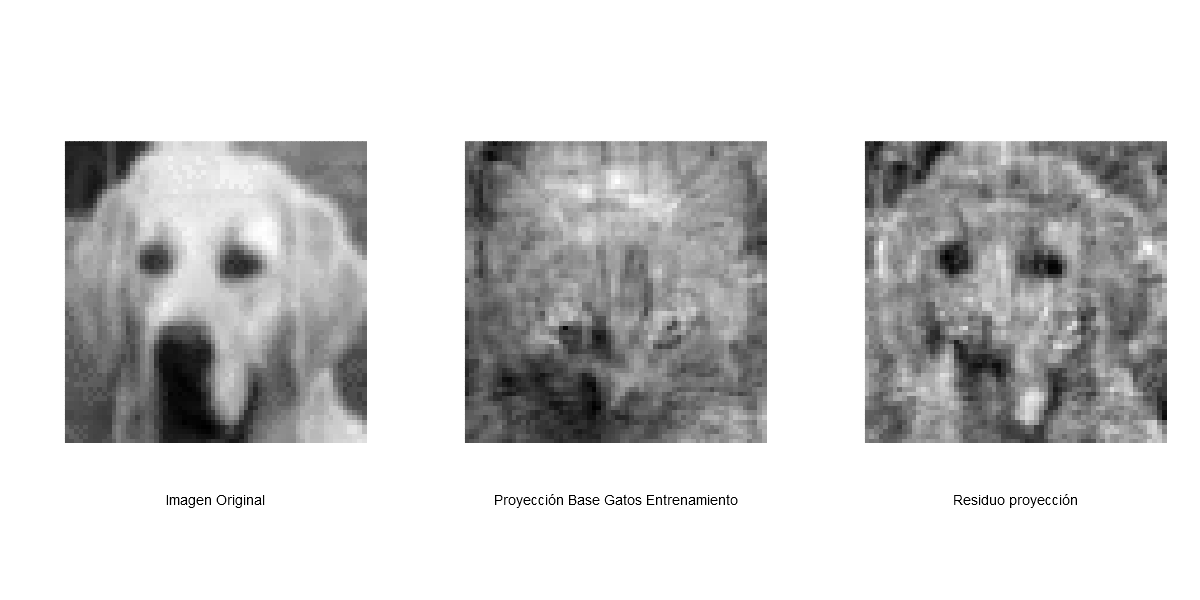

In [39]:
## Proyección de perros de entrenamiento
perros.train.proyec <- (perros.train %*% matriz.proyec) %*% t(matriz.proyec)
perros.train.resid <- perros.train - perros.train.proyec

## Parámetros de la gráfica
par(pty="s")
layout(matrix(1:3,1,3))

## Seleccionamos un perro de forma aleatoria
ind <- sample(1:nrow(perros.train),1)

## graficamos el perro seleccionado
plotcd(round(perros.train[ind,]))
title(xlab = "Imagen Original")
plotcd(round(perros.train.proyec[ind,]))
title(xlab="Proyección Base Gatos Entrenamiento")
plotcd(round(perros.train.resid[ind,]))
title(xlab = "Residuo proyección")

In [40]:
## Calculamos el error medio de proyección
perros.train.resid.norm <- apply(perros.train.resid, 1, norm, type="2")
mean(perros.train.resid.norm)

[1] 2583.06

### Replicamos sobre todos los perros
Buscamos evaluar el desempeño del método, por lo que replicaremos la transformación para todos los perros y estimaremos el error medio para cada perro, 